In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
##################################------Data Generators-------##############################

from keras.preprocessing.image import ImageDataGenerator

train_dir = r'/content/drive/MyDrive/face_detection_files/data/train'
#test_dir = r'/content/drive/MyDrive/face_detection_files/data/test'
val_dir = r'/content/drive/MyDrive/face_detection_files/data/val'


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=32,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')





Found 545 images belonging to 4 classes.
Found 66 images belonging to 4 classes.


In [3]:
##################################------Model-------##############################

from keras.applications.vgg16 import VGG16
from keras import models, layers, optimizers, regularizers
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization


conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())


model.add(layers.Dense(2048, activation='relu',kernel_regularizer=regularizers.l2(0.003)))#0.002
model.add(BatchNormalization())

model.add(layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.003)))#0.002
model.add(layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.003)))#0.002
model.add(BatchNormalization())

model.add(layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.003)))#0.002
model.add(layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.003)))#0.002
model.add(BatchNormalization())

model.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.003)))#0.002
model.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.003)))#0.002
model.add(BatchNormalization())

model.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.003)))#0.002
model.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.003)))#0.002
model.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.003)))#0.002
model.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.003)))#0.002

model.add(layers.Dense(4, activation='softmax'))
conv_base.trainable = False

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001,), metrics=['acc'])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4

In [5]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=1, patience=40, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)

In [8]:
print(len(validation_generator))

3


In [13]:
history = model.fit(train_generator, 
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=30, 
                    validation_steps=len(validation_generator),
                    callbacks=[es, reduce_lr])

Epoch 1/30
18/18 [==============================] - 7s 380ms/step - loss: 5.5098 - acc: 0.8422 - val_loss: 4.9591 - val_acc: 0.9394
Epoch 2/30
18/18 [==============================] - 7s 379ms/step - loss: 4.8425 - acc: 0.8477 - val_loss: 4.2867 - val_acc: 0.9091
Epoch 3/30
18/18 [==============================] - 7s 373ms/step - loss: 4.2714 - acc: 0.8422 - val_loss: 3.8434 - val_acc: 0.9091
Epoch 4/30
18/18 [==============================] - 7s 378ms/step - loss: 3.7820 - acc: 0.8532 - val_loss: 3.5787 - val_acc: 0.8636
Epoch 5/30
18/18 [==============================] - 7s 369ms/step - loss: 3.5458 - acc: 0.8367 - val_loss: 3.2172 - val_acc: 0.9242
Epoch 6/30
18/18 [==============================] - 7s 374ms/step - loss: 3.0834 - acc: 0.8734 - val_loss: 2.9368 - val_acc: 0.8485
Epoch 7/30
18/18 [==============================] - 7s 377ms/step - loss: 2.7036 - acc: 0.8862 - val_loss: 2.6526 - val_acc: 0.7576
Epoch 8/30
18/18 [==============================] - 7s 379ms/step - loss: 2.

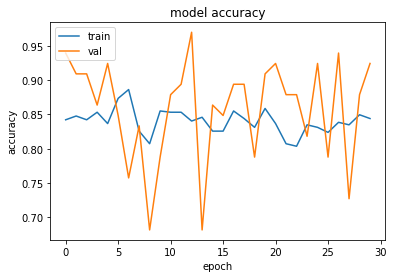

In [14]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

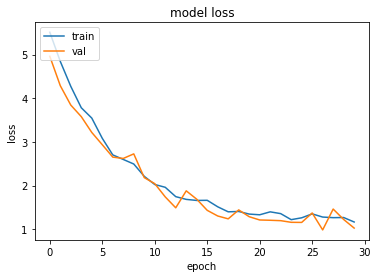

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
model.save('/content/drive/MyDrive/face_detection_files/vgg16_30ep.h5')